In [1]:
import tensorflow as tf
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, GlobalAveragePooling2D, add, average, \
    maximum
# import tensorflow_addons as tfa

import tensorflow_datasets as tfds
# import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
# import shutil

# from PIL import Image

In [2]:
# from tensorflow_docs import modeling

In [3]:
tfds.disable_progress_bar()  # disable tqdm progress bar
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)


In [5]:
print("TensorFlow Version: ", tf.__version__)
print("Number of GPU available: ", len(tf.config.experimental.list_physical_devices("GPU")))

TensorFlow Version:  2.1.0
Number of GPU available:  1


In [6]:
def read_and_label(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    label = get_label(file_path)
    # crop = 1
    # img = no_nuc(img,file_path,crop)
    return img, label


def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.reshape(tf.where(parts[-4] == CLASS_NAMES), [])


def augment(image, label):
    image = tf.image.random_hue(image, max_delta=0.04, seed=5)
    image = tf.image.random_contrast(image, 0.9, 1.1, seed=5)  # tissue quality
    image = tf.image.random_saturation(image, 0.9, 1.1, seed=5)  # stain quality
    image = tf.image.random_brightness(image, max_delta=0.1)  # tissue thickness, glass transparency (clean)
    image = tf.image.random_flip_left_right(image, seed=5)  # cell orientation
    image = tf.image.random_flip_up_down(image, seed=5)  # cell orientation
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # cell orientation
    return image, label

def no_nuc(image,file_path,crop):
    maskpth = tf.strings.regex_replace(file_path,'image','label')
    mask = tf.io.read_file(maskpth)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float16)
    mask = tf.image.resize(mask, [IMG_WIDTH, IMG_HEIGHT])
    mask = tf.image.central_crop(mask,crop)
    image = tf.image.central_crop(image,crop)
    mask = tf.math.greater(mask, 0.25)
    mask = tf.math.logical_not(mask)
    maskedimg = tf.where(mask, image, tf.ones(tf.shape(image)))
    return maskedimg
    # return tf.image.resize(maskedimg, [32, 32])

In [7]:
def balance(data_dir):
    tmp = [0]
    for CLASS, n in zip(CLASS_NAMES, samplesize):
        secs = [_ for _ in data_dir.glob(CLASS+'/*')]
        for idx,sec in enumerate(secs):
            sec = os.path.join(sec, 'image/*.jpg')
            list_ds = tf.data.Dataset.list_files(sec)
            # subsample
            list_ds = (list_ds
                       .shuffle(shuffle_buffer_size)
                       .take(n)
                       )
            labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)

            # add augment
            sampleN = len(list(labeled_ds))
            while sampleN < n:
                labeled_ds_aug = (labeled_ds
                                  .shuffle(shuffle_buffer_size)
                                  .take(n-sampleN)
                                  .map(augment,num_parallel_calls=AUTOTUNE)
                                  )
                labeled_ds = labeled_ds.concatenate(labeled_ds_aug)
                sampleN = len(list(labeled_ds))
            print('list_ds: ', len(list(labeled_ds)),CLASS)
            # append
            if tmp[0] == 0:
                tmp[idx] = labeled_ds
            else:
                labeled_ds = tmp[0].concatenate(labeled_ds)
                tmp[0] = labeled_ds
        # print(CLASS, ': sample size =', len(list(tmp[0])))
    return tmp[0].shuffle(shuffle_buffer_size)

In [8]:
shuffle_buffer_size = 1000  # take first 100 from dataset and shuffle and pick one.
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 128
val_fraction = 30
samplesize = [300, 400] #young, old
# list location of all training images
train_data_dir = test_data_dir = '/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train'
train_data_dir = pathlib.Path(train_data_dir)
CLASS_NAMES = np.array(
    [item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_store"])
CLASS_NAMES = sorted(CLASS_NAMES, key=str.lower)

In [9]:
# tf.executing_eagerly()
# tf.compat.v1.disable_eager_execution()
# tf.executing_eagerly()

In [10]:
# list_ds = tf.data.Dataset.list_files('/home/kuki/Desktop/Research/cnn_dataset/train/young/sec001/image/*.jpg')
# for file_path in list_ds.take(1):
#     image = tf.io.read_file(file_path)
#     image = decode_img(image)
#     plt.imshow(image)


In [11]:
train_labeled_ds = balance(train_data_dir)
train_image_count = len(list(train_labeled_ds))
print('training set size : ', train_image_count)
val_image_count = train_image_count // 100 * val_fraction
print('validation size: ', val_image_count)
train_image_count2 = train_image_count-val_image_count
print('training set size after split : ', train_image_count2)
STEPS_PER_EPOCH = train_image_count2 // BATCH_SIZE
VALIDATION_STEPS = val_image_count // BATCH_SIZE

list_ds:  300 old
list_ds:  300 old
list_ds:  300 old
list_ds:  300 old
list_ds:  300 old
list_ds:  300 old
list_ds:  300 old
list_ds:  300 old
list_ds:  400 young
list_ds:  400 young
list_ds:  400 young
list_ds:  400 young
list_ds:  400 young
list_ds:  400 young
training set size :  4800
validation size:  1440
training set size after split :  3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

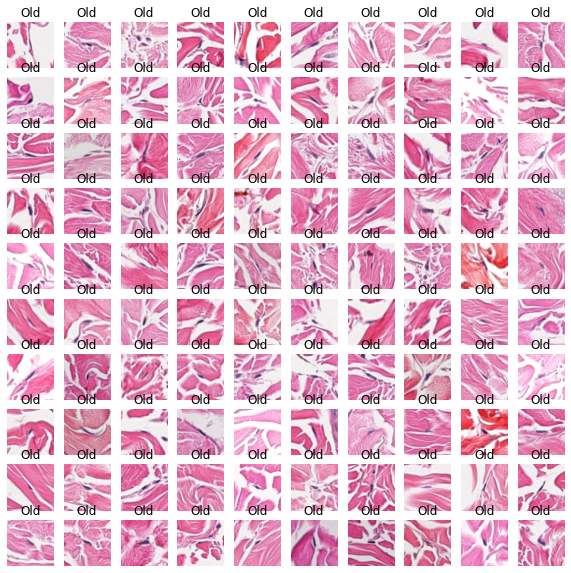

In [12]:
plt.figure(figsize=(10,10))
for idx, elem in enumerate(train_labeled_ds.take(100)):
    img = elem[0]
    label = elem[1]
    ax = plt.subplot(10,10,idx+1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label].title())
    plt.axis('off')
plt.show()

In [13]:
img.shape

TensorShape([100, 100, 3])

list_ds:  300 old
list_ds:  300 old
list_ds:  300 old
list_ds:  300 old
list_ds:  400 young
list_ds:  400 young
list_ds:  400 young
test set size :  2400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

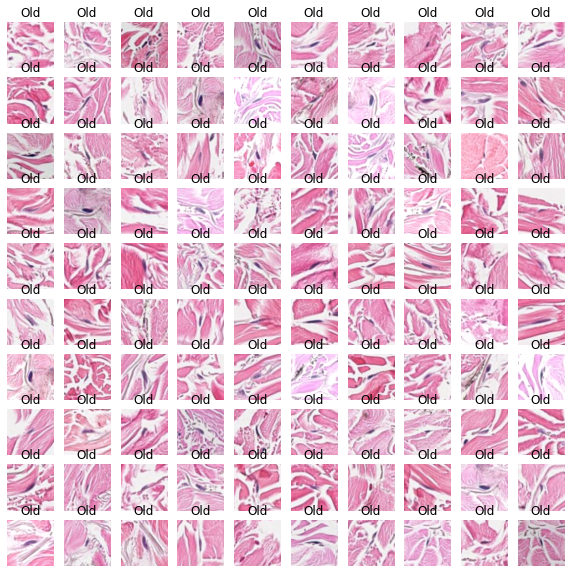

In [14]:
train_ds = (train_labeled_ds
            .skip(val_image_count)
            # .cache("./cache/fibro_train.tfcache")
            .shuffle(buffer_size=shuffle_buffer_size)
            .repeat()
            .batch(BATCH_SIZE)
            .map(augment, num_parallel_calls=AUTOTUNE) #always batch before mapping
            .prefetch(buffer_size=AUTOTUNE)
            )

val_ds = (train_labeled_ds
          .take(val_image_count)
          # .cache("./cache/fibro_val.tfcache")
          .repeat()
          .batch(BATCH_SIZE)
          .prefetch(buffer_size=AUTOTUNE))

test_data_dir = '/home/kuki/Desktop/Synology/aging/data/cnn_dataset/test'
test_data_dir = pathlib.Path(test_data_dir)
test_labeled_ds = balance(test_data_dir)

plt.figure(figsize=(10,10))
for idx,elem in enumerate(test_labeled_ds.take(100)):
    img = elem[0]
    label = elem[1]
    ax = plt.subplot(10,10,idx+1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label].title())
    plt.axis('off')
plt.show()


test_ds = (test_labeled_ds
           # .cache("./cache/fibro_test.tfcache")
           .shuffle(buffer_size=shuffle_buffer_size)
           .repeat()
           .batch(BATCH_SIZE)
           .prefetch(buffer_size=AUTOTUNE)  # time it takes to produce next element
           )
test_image_count = len(list(test_labeled_ds))
print('test set size : ', test_image_count)
TEST_STEPS = test_image_count // BATCH_SIZE

In [15]:
checkpoint_dir = "training_1"
# shutil.rmtree(checkpoint_dir, ignore_errors=True)

def get_callbacks(name):
    return [
        # modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_crossentropy',
                                         patience=50, restore_best_weights=True),
        # tf.keras.callbacks.TensorBoard(log_dir/name, histogram_freq=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + "/{}/cp.ckpt".format(name),
                                           verbose=0,
                                           monitor='val_sparse_categorical_crossentropy',
                                           save_weights_only=True,
                                           save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_crossentropy',
                                             factor=0.1, patience=10, verbose=0, mode='auto',
                                             min_delta=0.0001, cooldown=0, min_lr=0),
    ]

def compilefit(model, name, max_epochs=300):
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'accuracy'])
    model_history = model.fit(train_ds,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=max_epochs,
                              verbose=0,
                              validation_data=val_ds,
                              callbacks=get_callbacks(name),
                              validation_steps=VALIDATION_STEPS,
                              use_multiprocessing=True
                              )
    namename = os.path.dirname(name)
    if not os.path.isdir(os.path.abspath(namename)):
        os.mkdir(os.path.abspath(namename))
    if not os.path.isdir(os.path.abspath(name)):
        os.mkdir(os.path.abspath(name))
    if not os.path.isfile(pathlib.Path(name) / 'full_model.h5'):
        try:
            model.save(pathlib.Path(name) / 'full_model.h5')
        except:
            print('model not saved?')

    return model_history


def plotdf(dfobj, condition, lr=None):
    pd.DataFrame(dfobj).plot(title=condition)
    dfobj.pop('loss')
    dfobj.pop('val_loss')
    dfobj1 = dfobj.copy()
    dfobj2 = dfobj.copy()
    dfobj.pop('lr')
    dfobj.pop('sparse_categorical_crossentropy')
    dfobj.pop('val_sparse_categorical_crossentropy')
    pd.DataFrame(dfobj).plot(title=condition)
    dfobj1.pop('lr')
    dfobj1.pop('accuracy')
    dfobj1.pop('val_accuracy')
    pd.DataFrame(dfobj1).plot(title=condition)
    if lr is not 'decay':
        dfobj2.pop('sparse_categorical_crossentropy')
        dfobj2.pop('val_sparse_categorical_crossentropy')
        dfobj2.pop('accuracy')
        dfobj2.pop('val_accuracy')
        pd.DataFrame(dfobj2).plot(title=condition)
    plt.show()

def evaluateit(network,networkname):
    with tf.device('/device:GPU:0'):
        histories[networkname] = compilefit(network, 'cnn/'+networkname, max_epochs=300)
        results = network.evaluate(test_ds, steps=TEST_STEPS)
    plotdf(histories[networkname].history,networkname)
    print('test acc', results[-1] * 100)

def load_dataset(dataset_dir):
    dataset_dir = pathlib.Path(dataset_dir)
    test_image_count2 = len(list(dataset_dir.glob('image/*.jpg')))
    list_ds = tf.data.Dataset.list_files(str(dataset_dir / 'image/*.jpg'))
    labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
    return labeled_ds, test_image_count2


def evalmodels(path, model):
    datasett, datasettsize = load_dataset(path)
    print('datasetsize',datasettsize)
    results = model.evaluate(datasett.batch(1000))
    aa.append(np.around(results[-1] * 100, decimals=1))

In [16]:
histories = {}

In [17]:
# min input 32x32
ResV2_base = tf.keras.applications.ResNet101V2(input_shape=(100, 100, 3),
                                            pooling='avg',
                                            include_top=False,
                                            weights=None
                                            )
ResV2 = tf.keras.Sequential([
    ResV2_base,
    Dense(2, activation='softmax')
])
evaluateit(ResV2,'ResV2_none')

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/resnet101v2/conv1_conv/Conv2D (defined at <ipython-input-15-dede48146508>:31) ]] [Op:__inference_distributed_function_93415]

Function call stack:
distributed_function


In [ ]:
# ResV2_base_2 = tf.keras.applications.ResNet101V2(input_shape=(100, 100, 3),
#                                             pooling='avg',
#                                             include_top=False,
#                                             weights='imagenet'
#                                             )
# ResV2_2 = tf.keras.Sequential([
#     ResV2_base_2,
#     Dense(2, activation='softmax')
# ])
# evaluateit(ResV2_2,'ResV2')
#

In [ ]:
# #min input size 76x76
# IncV3_base = tf.keras.applications.InceptionV3(input_shape=(100, 100, 3),
#                                             pooling=None,
#                                             include_top=False,
#                                             weights='imagenet'
#                                             )
# IncV3 = tf.keras.Sequential([
#     IncV3_base,
#     Dense(2, activation='softmax')
# ])
# evaluateit(IncV3,'IncV3')
#

In [ ]:
# InceptionResNetV2_base = tf.keras.applications.InceptionResNetV2(input_shape=(100, 100, 3),
#                                             pooling=None,
#                                             include_top=False,
#                                             weights='imagenet'
#                                             )
# InceptionResNetV2 = tf.keras.Sequential([
#     InceptionResNetV2_base,
#     Dense(2, activation='softmax')
# ])
# evaluateit(InceptionResNetV2,'InceptionResNetV2')

In [ ]:
def load_compile(net):
    model = tf.keras.models.load_model('cnn/' + net + '/full_model.h5', compile=False,
                                       # custom_objects={'KerasLayer': hub.KerasLayer}
                                       )
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model


ResV2 = load_compile('ResV2_collagen')
ResV2_none = load_compile('ResV2_none_collagen')
IncV3 = load_compile('IncV3_collagen')
InceptionResNetV2 = load_compile('InceptionResNetV2_collagen')

In [ ]:
ms = [ResV2, ResV2_none, IncV3, InceptionResNetV2]

for m in ms:
    aa=[]
    print('young train')
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/young/sec001',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/young/sec003',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/young/sec007',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/young/sec010',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/young/sec016',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/young/sec019',m)
    print('young test')
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/test/young/sec023',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/test/young/sec025',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/test/young/sec029',m)
    print('old train')
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/old/sec031',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/old/sec037',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/old/sec041',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/old/sec045',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/old/sec049',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/old/sec062',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/old/sec068',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/train/old/sec070',m)
    print('old test')
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/test/old/sec076',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/test/old/sec078',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/test/old/sec082',m)
    evalmodels('/home/kuki/Desktop/Research/cnn_dataset/test/old/sec088',m)
    print(aa)